### Take a look at the detectors in R11, and compare them across Run 6 and 6b to see what, if any differences are present

Keep in mind, the main difference is in the flagging of the picture frame, but there may be other defects present

In [1]:
import sys
sys.path.append('/home/s/seanmacb/pkgs')
import myutils_ar.myutils as myu
import eo_pipe
import lsst.daf.butler as daf_butler
from lsst.obs.lsst import LsstCam, LsstTS8
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1 import make_axes_locatable
import lsst.geom
from lsst.afw import cameraGeom
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib') 
import pandas as pd
import matplotlib.ticker as ticker
from scipy.stats import norm
from matplotlib.ticker import FormatStrFormatter
import run_six_utils as rsu

In [2]:
# Get a list of all of the detectors in R11

raft_11_dets = np.arange(36,45)

for number in raft_11_dets:
    print(number,rsu.get_serial_from_number([number])[0],LsstCam.getCamera().getIdMap()[number].getName()[:3])

# Conclusion: detectors 36-44 are the interesting ones

36 E2V R11
37 E2V R11
38 E2V R11
39 E2V R11
40 E2V R11
41 E2V R11
42 E2V R11
43 E2V R11
44 E2V R11


In [3]:
# Get one detector from each run
# What runs for 6, 6b?
# 6: 13391. 6b: 13550
run_num = [13401,13550]

repo_path = "/repo/ir2" # The path where the data taken in the ir2 cleanroom is stored
butler = daf_butler.Butler(repo_path) # Initializing a Butler
collections = 'LSSTCam/raw/all,LSSTCam/calib'.split(",") # Defining collections (that are ignored by below kernel)
butler = daf_butler.Butler(repo_path,collections=collections) # Initializing a butler with the ir2 path and the above collections
registry = butler.registry # converting the butler to a RegistryShim to query the datatypes

### Debugs here

In [4]:
print_runs = True
if print_runs:
    for run in run_num:
        print(run,"\n",10*"----")
        run_list = list(registry.queryCollections(f'*{run}*'))
        for item in run_list:
            if item.__contains__('flat') or item.__contains__('defects'):
                print(item)
        print("\n")
        # print(run_list[run_list.__contains__("defect")])# Querying to find collections that have 13550 in their paths

13401 
 ----------------------------------------
u/lsstccs/eo_bright_defects_13401_w_2023_24/20230623T165706Z
u/lsstccs/flat_13401_w_2023_24/20230623T105706Z
u/lsstccs/defects_13401_w_2023_24/20230623T112702Z
u/lsstccs/eo_dark_defects_13401_w_2023_24/20230623T165845Z
u/lsstccs/defects_13401_w_2023_24
u/lsstccs/eo_dark_defects_13401_w_2023_24
u/lsstccs/eo_bright_defects_13401_w_2023_24
u/lsstccs/flat_13401_w_2023_24


13550 
 ----------------------------------------
u/lsstccs/flat_13550_w_2023_41/20231116T222024Z
u/lsstccs/defects_13550_w_2023_41/20231116T223108Z
u/lsstccs/eo_bright_defects_13550_w_2023_41/20231117T000800Z
u/lsstccs/eo_dark_defects_13550_w_2023_41/20231117T000846Z
u/lsstccs/flat_13550_w_2023_41
u/lsstccs/defects_13550_w_2023_41
u/lsstccs/eo_bright_defects_13550_w_2023_41
u/lsstccs/eo_dark_defects_13550_w_2023_41




In [5]:
for detec in np.arange(10,200,step=10):
    print("Detector #",detec,rsu.get_serial_from_number([detec])[0],"\n",10*"---")
    defec = rsu.getImage("bias","13391_w_2023_24",detec)
    for key,val in zip(defec.getMetadata().toDict().keys(),defec.getMetadata().toDict().values()):
        if key.__contains__("LSST GAIN") and val<1.3:
            print(key,val)

Detector # 10 ITL 
 ------------------------------
Detector # 20 ITL 
 ------------------------------
Detector # 30 ITL 
 ------------------------------
Detector # 40 E2V 
 ------------------------------
LSST GAIN C10 1.07176
LSST GAIN C11 1.08357
LSST GAIN C12 1.08024
LSST GAIN C13 1.08566
LSST GAIN C14 1.0793
LSST GAIN C15 1.08231
LSST GAIN C16 1.07014
LSST GAIN C17 1.07795
LSST GAIN C07 1.11147
LSST GAIN C06 1.10449
LSST GAIN C05 1.11061
LSST GAIN C04 1.11317
LSST GAIN C03 1.11843
LSST GAIN C02 1.11708
LSST GAIN C01 1.12517
LSST GAIN C00 1.14034
Detector # 50 E2V 
 ------------------------------
LSST GAIN C10 1.21624
LSST GAIN C11 1.2136
LSST GAIN C12 1.21047
LSST GAIN C13 1.20648
LSST GAIN C14 1.21927
LSST GAIN C15 1.20251
LSST GAIN C16 1.20489
LSST GAIN C17 1.20332
LSST GAIN C07 1.16166
LSST GAIN C06 1.15902
LSST GAIN C05 1.15711
LSST GAIN C04 1.15476
LSST GAIN C03 1.15483
LSST GAIN C02 1.15322
LSST GAIN C01 1.14785
LSST GAIN C00 1.1645
Detector # 60 E2V 
 ------------------------

# Make sure they are gain corrected!!
# Look at the metadata and ensure ISR has the right gains (~1.5)
# Write a function to display images from two detectors next to each other
# Iterate over all of the detectors

In [4]:
# These are the interesting collections

collections_interesting = {run_num[0]:["u/lsstccs/defects_13401_w_2023_24","u/lsstccs/eo_dark_defects_13401_w_2023_24","u/lsstccs/eo_bright_defects_13401_w_2023_24","u/lsstccs/flat_13401_w_2023_24"],
                          run_num[1]:["u/lsstccs/defects_13550_w_2023_41","u/lsstccs/eo_dark_defects_13550_w_2023_41","u/lsstccs/eo_bright_defects_13550_w_2023_41","u/lsstccs/flat_13550_w_2023_41"]}

In [5]:
weekly = []
for val in collections_interesting.values():
    for val2 in val:
        # val2[10:] is everything without the 'u/lsstccs/'
        if val2[-15:] not in weekly:
            weekly.append(val2[-15:])

In [6]:
run = str(run_num[0])
collection = collections_interesting[int(run)][0]

Detector: 36
------------------------------


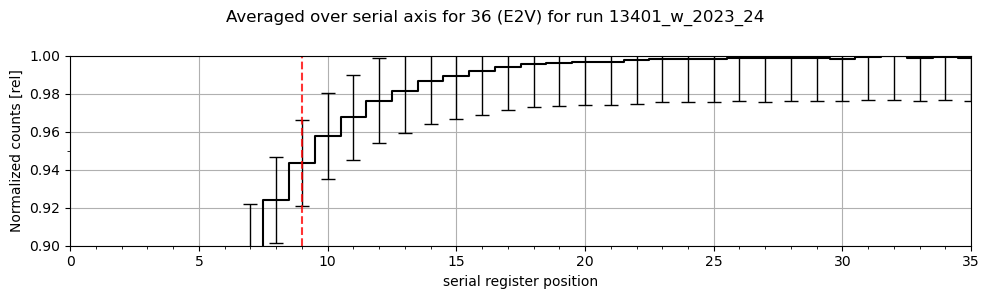

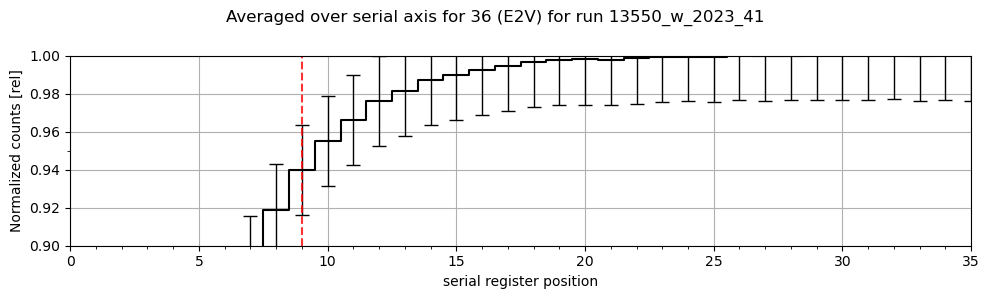

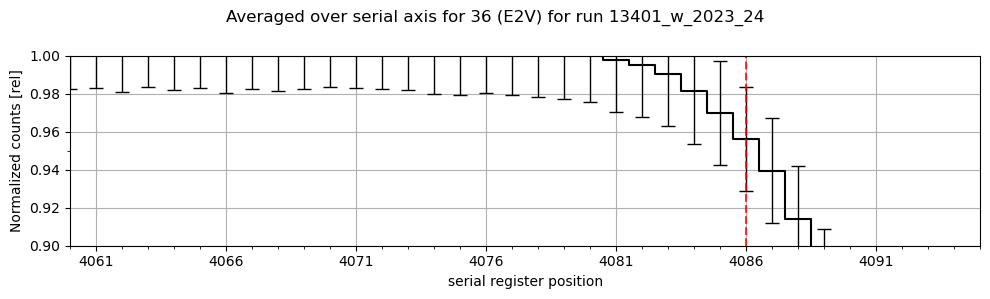

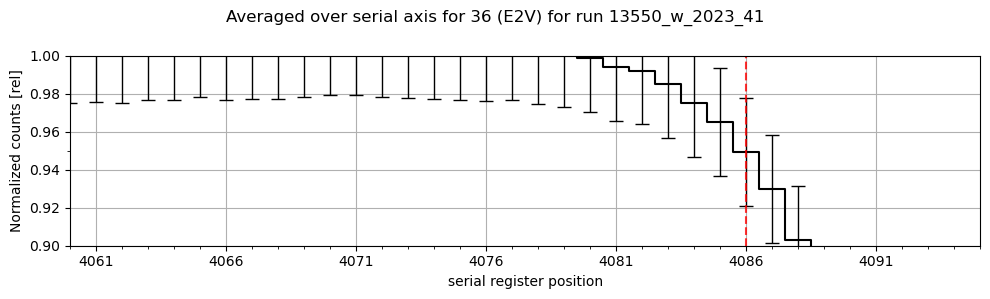

Detector: 37
------------------------------


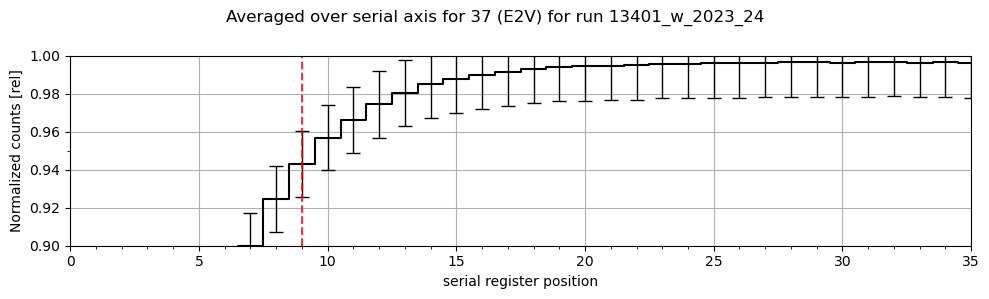

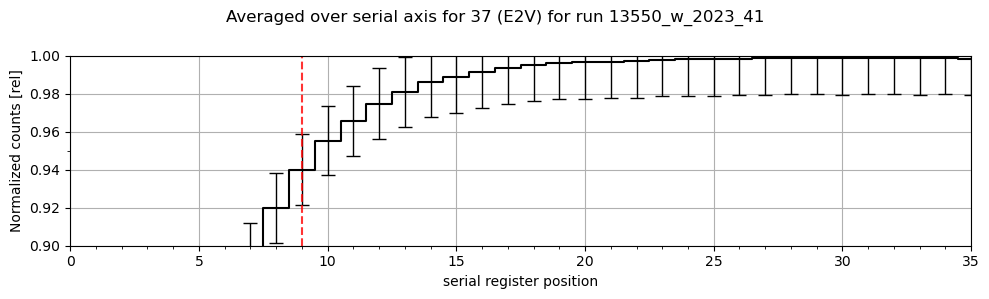

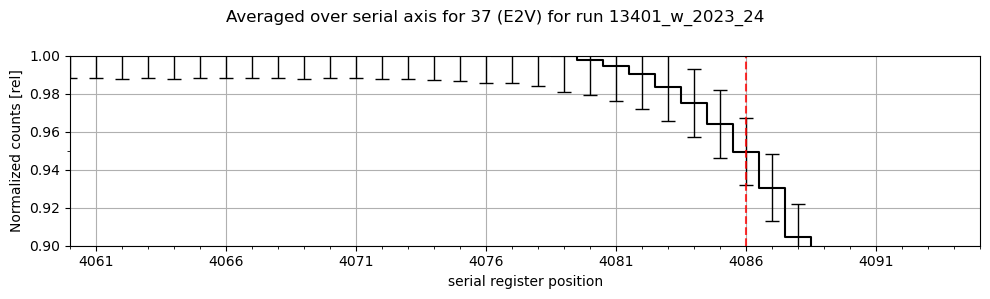

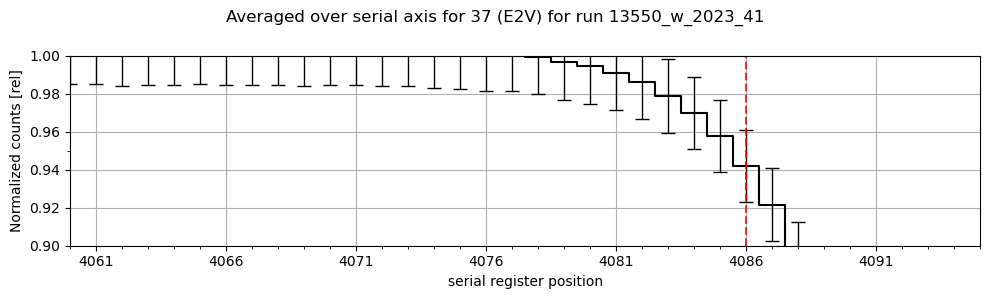

Detector: 38
------------------------------


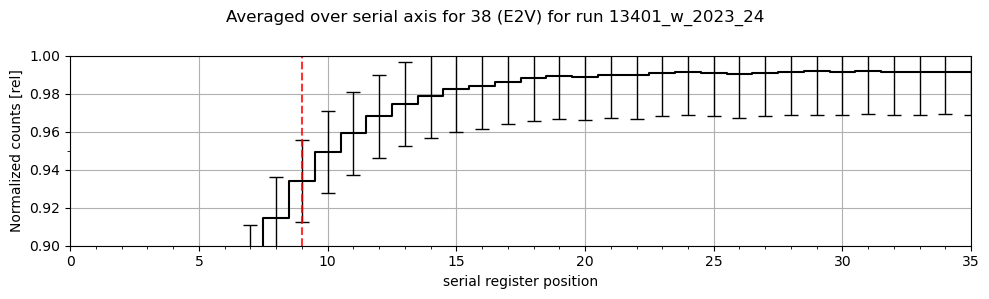

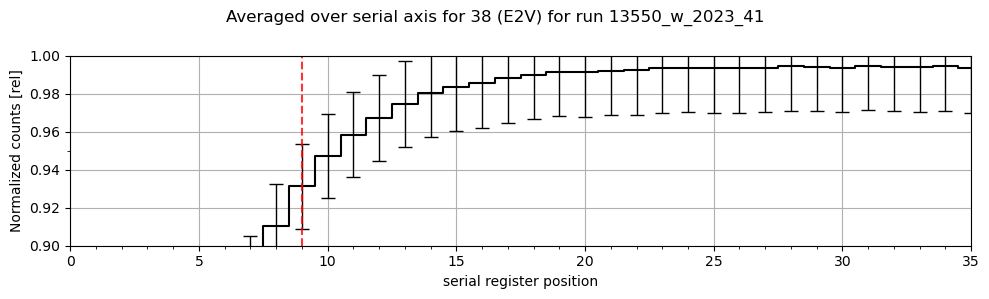

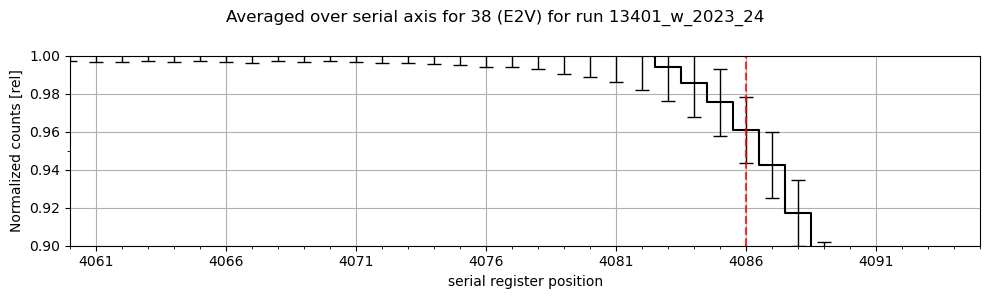

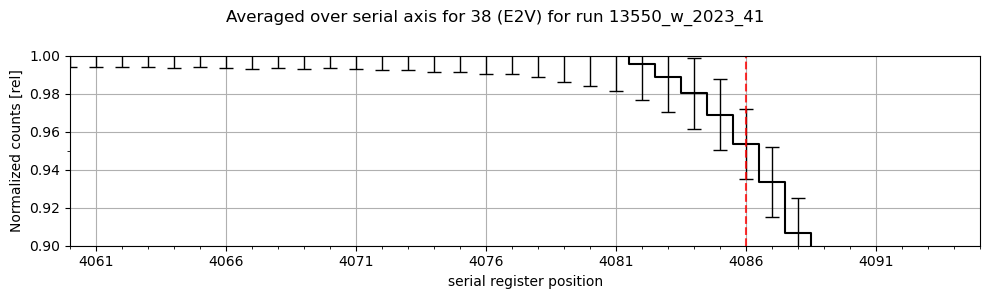

Detector: 39
------------------------------


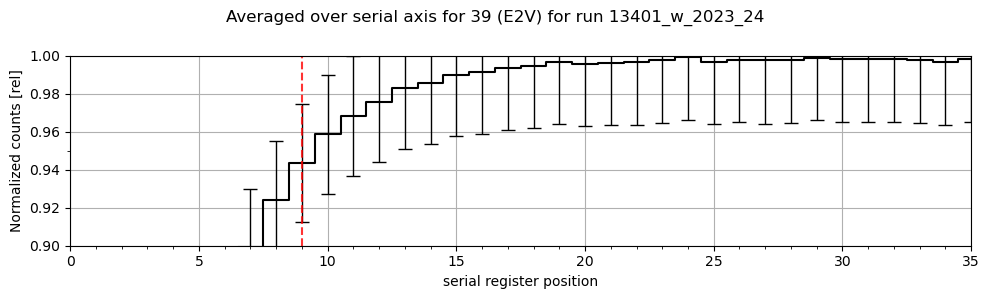

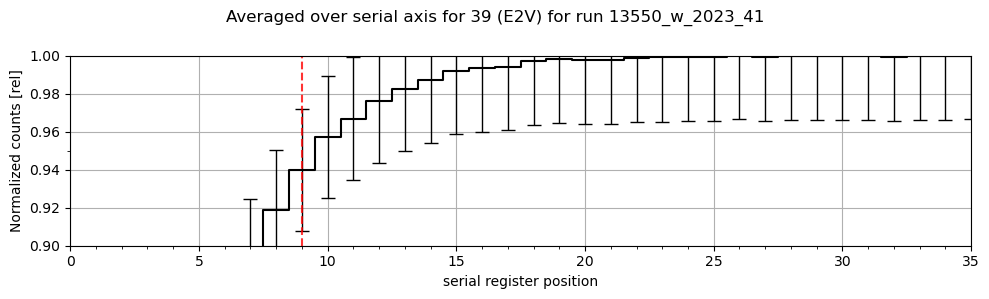

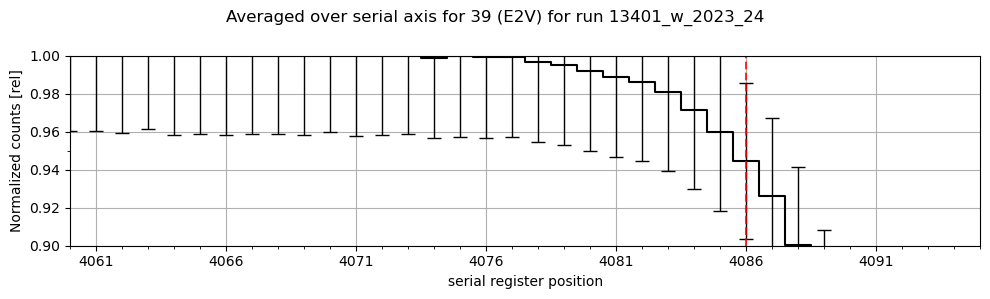

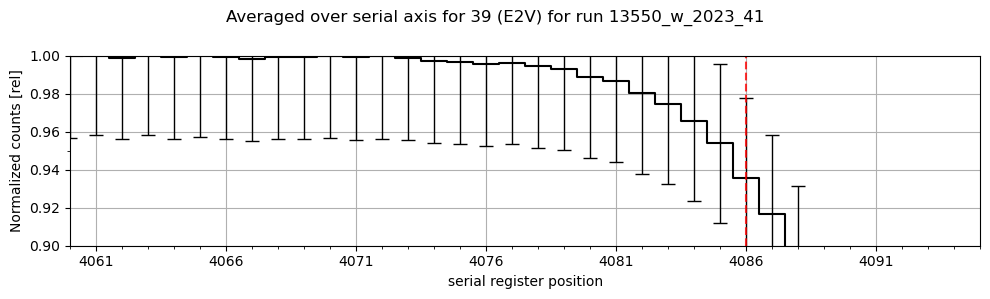

Detector: 40
------------------------------


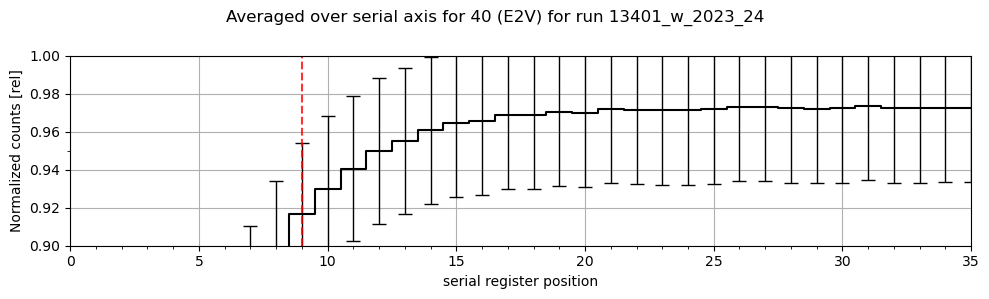

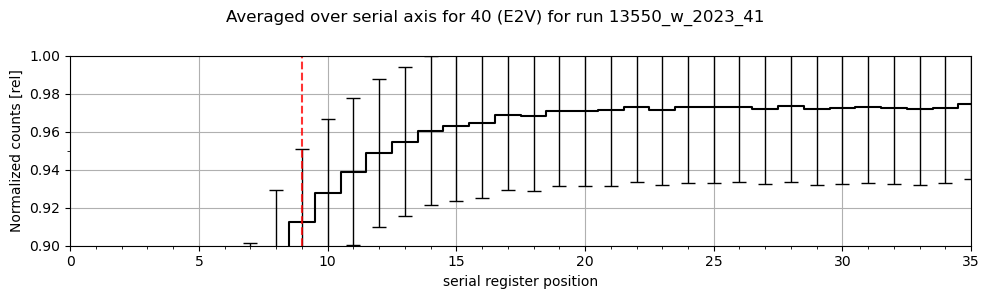

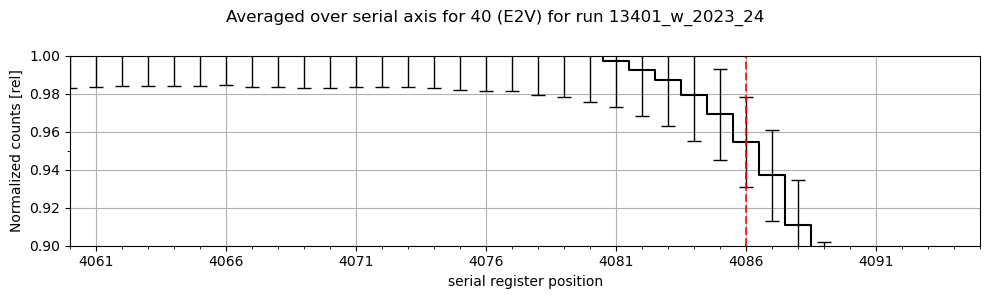

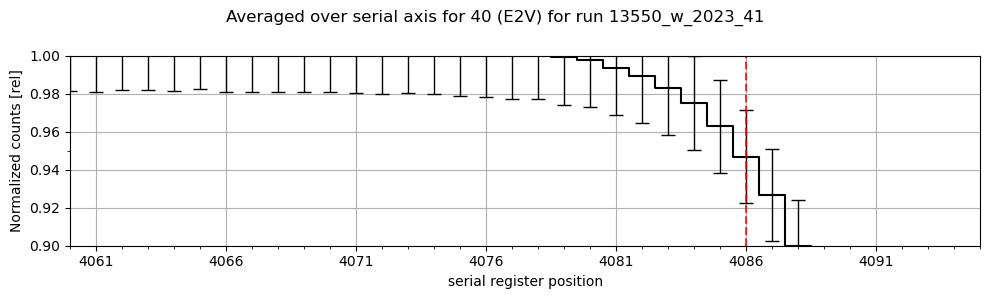

Detector: 41
------------------------------


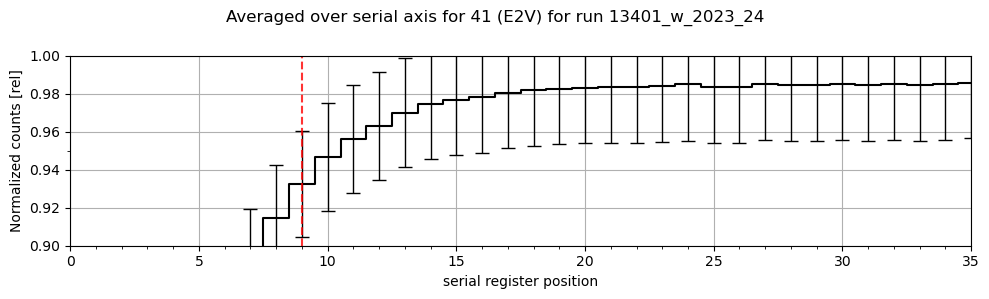

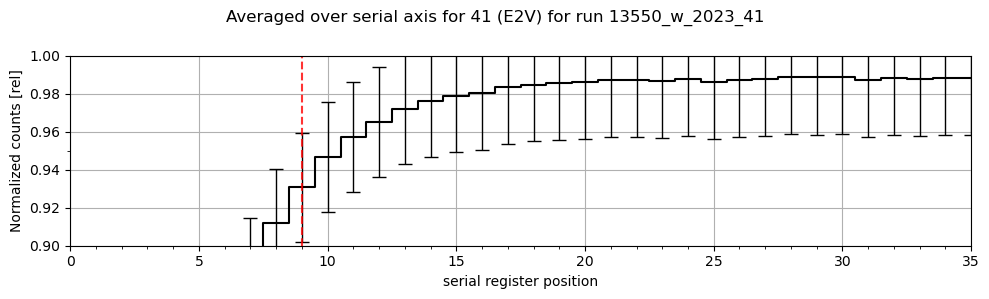

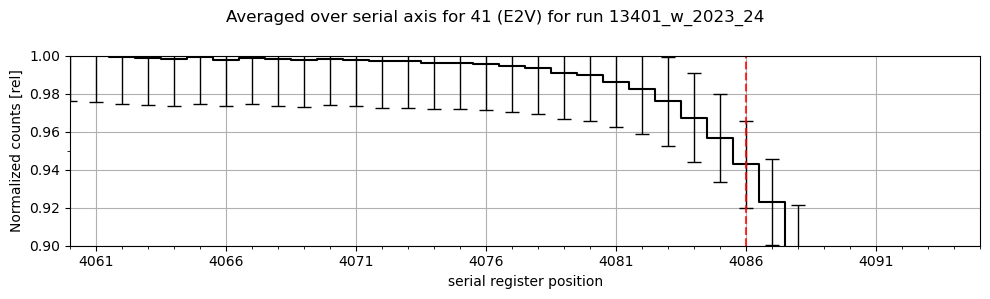

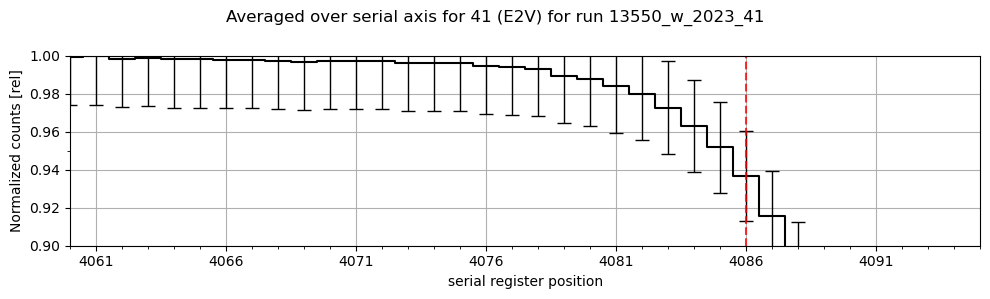

Detector: 42
------------------------------


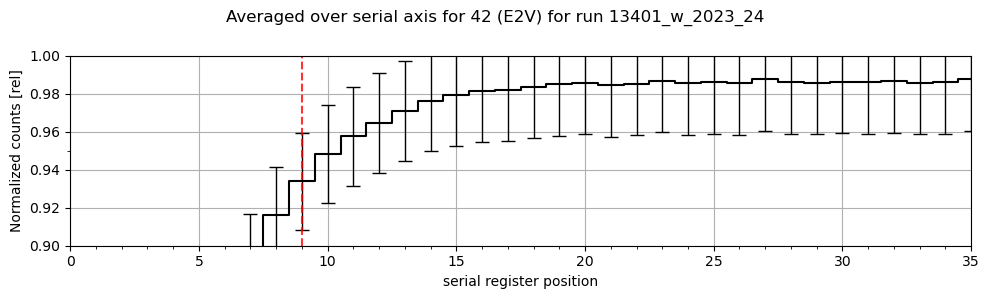

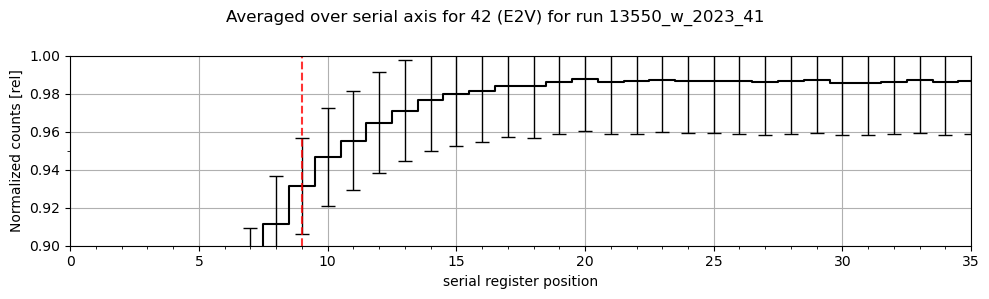

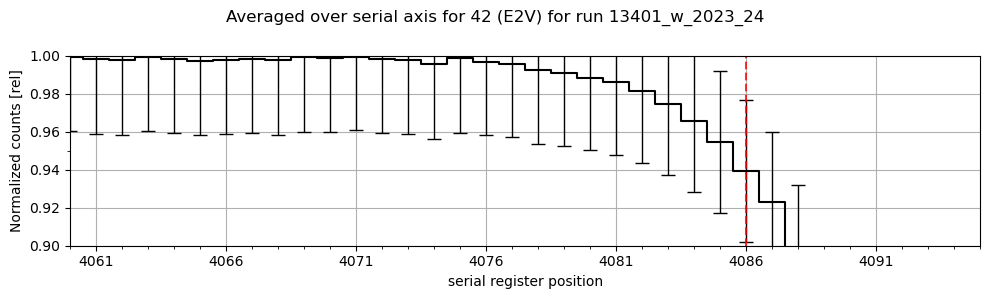

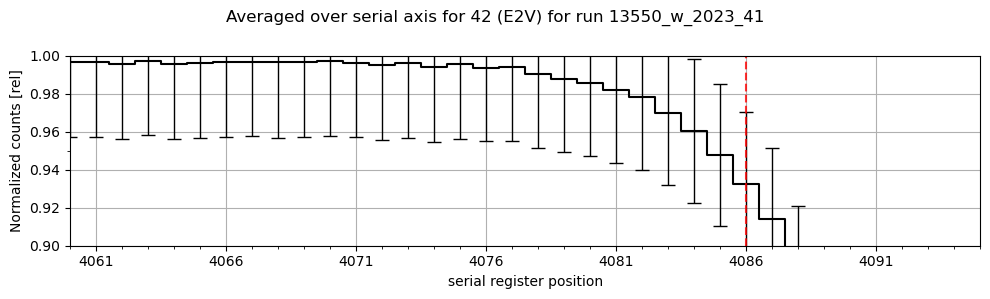

Detector: 43
------------------------------


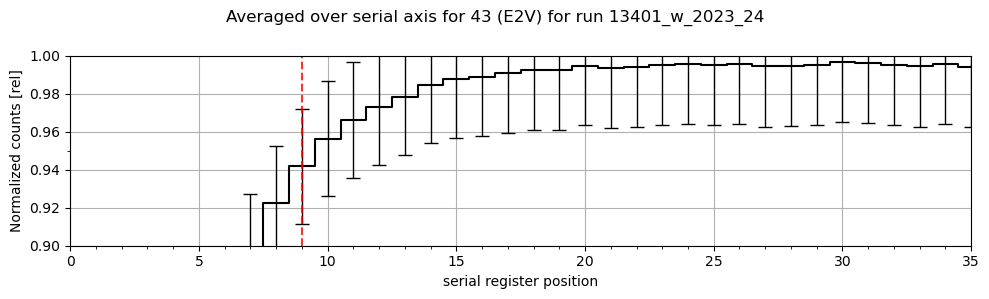

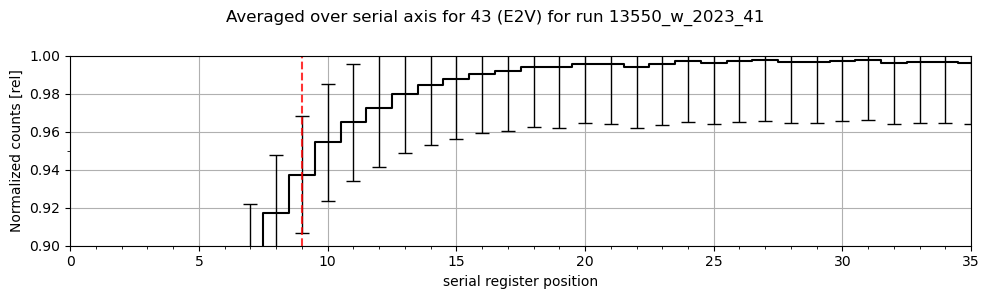

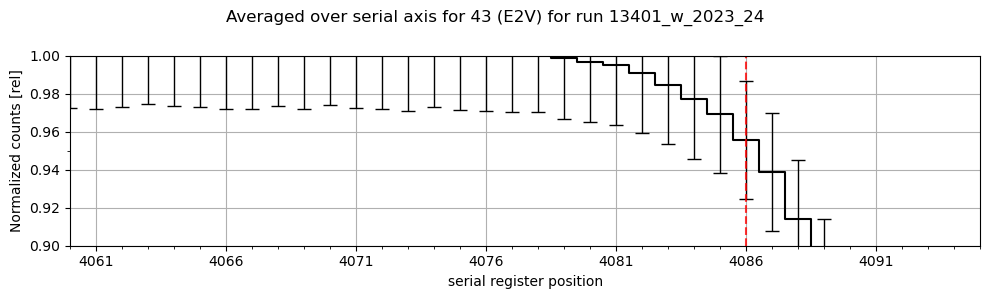

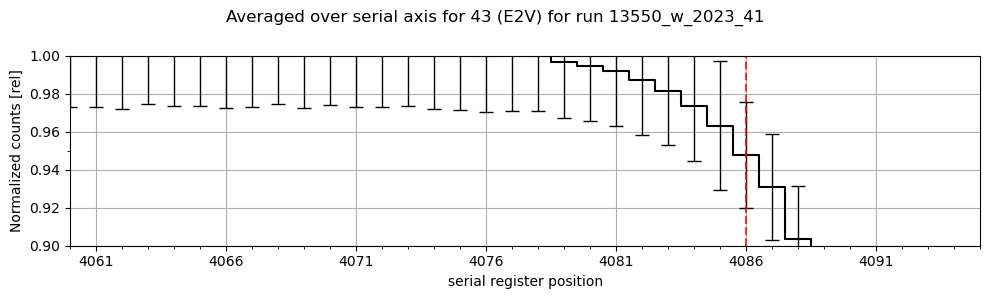

Detector: 44
------------------------------


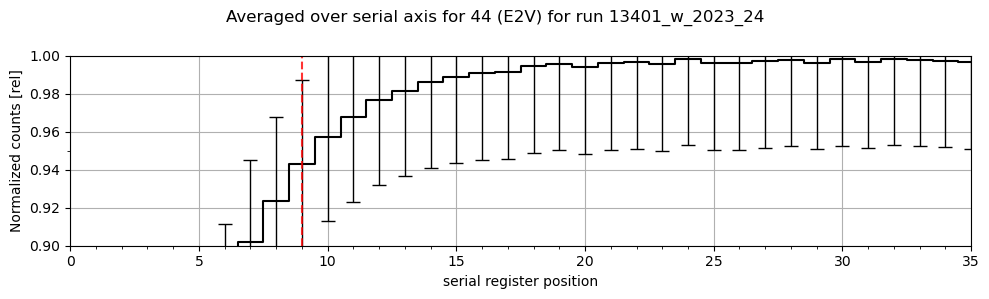

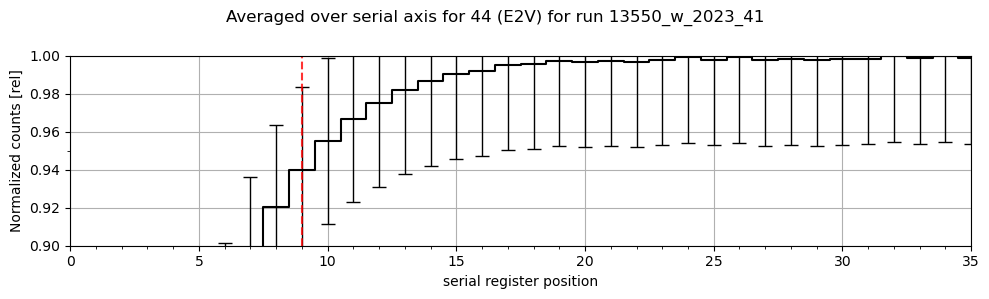

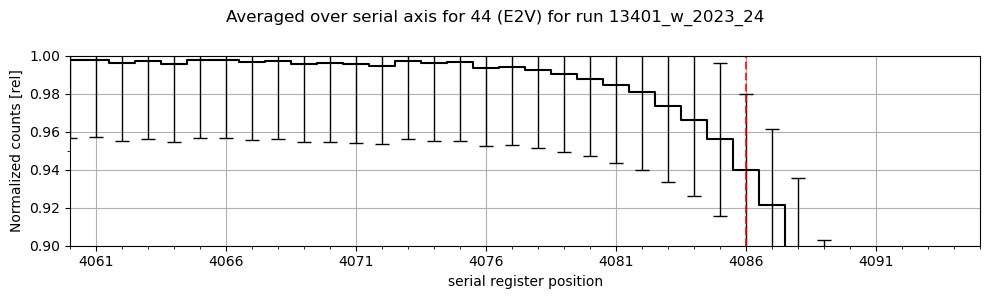

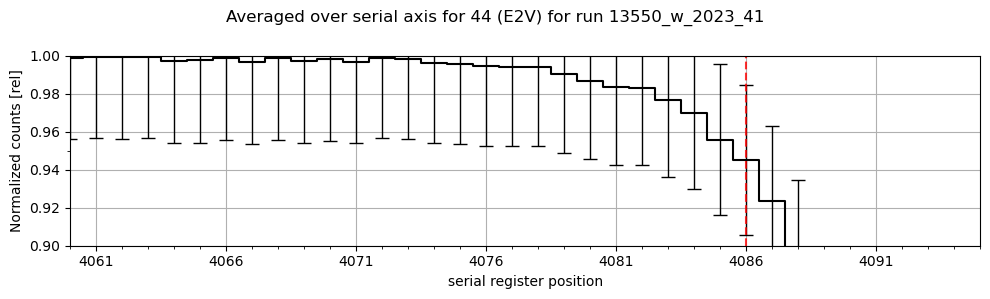

In [7]:
img = 'flat'


for detectah in raft_11_dets:
    print("Detector:",detectah)
    print(10*'---')
    for left in [True,False]:
        for week in weekly:
            fig = rsu.generate1DStatistics_oneDetector(img,week,detectah,'x',tight=True,norm=True,median=True,edge=True,threshold=False,ylim=(0.9,1),figsize=[10,3],left=left,runlabel=week,withLCA=True).show()
            plt.show()
            # fig.clear()
            plt.close(fig)

## Stack all similar detectors to compare between 6 and 6b

In [7]:
save=False
colors=["#332288", "#88CCEE", "#44AA99", "#117733", "#999933", "#DDCC77", "#CC6677", "#882255", "#AA4499"]

Finished for run 13401 and left edge
Finished for run 13401 and right edge
Finished for run 13550 and left edge
Finished for run 13550 and right edge


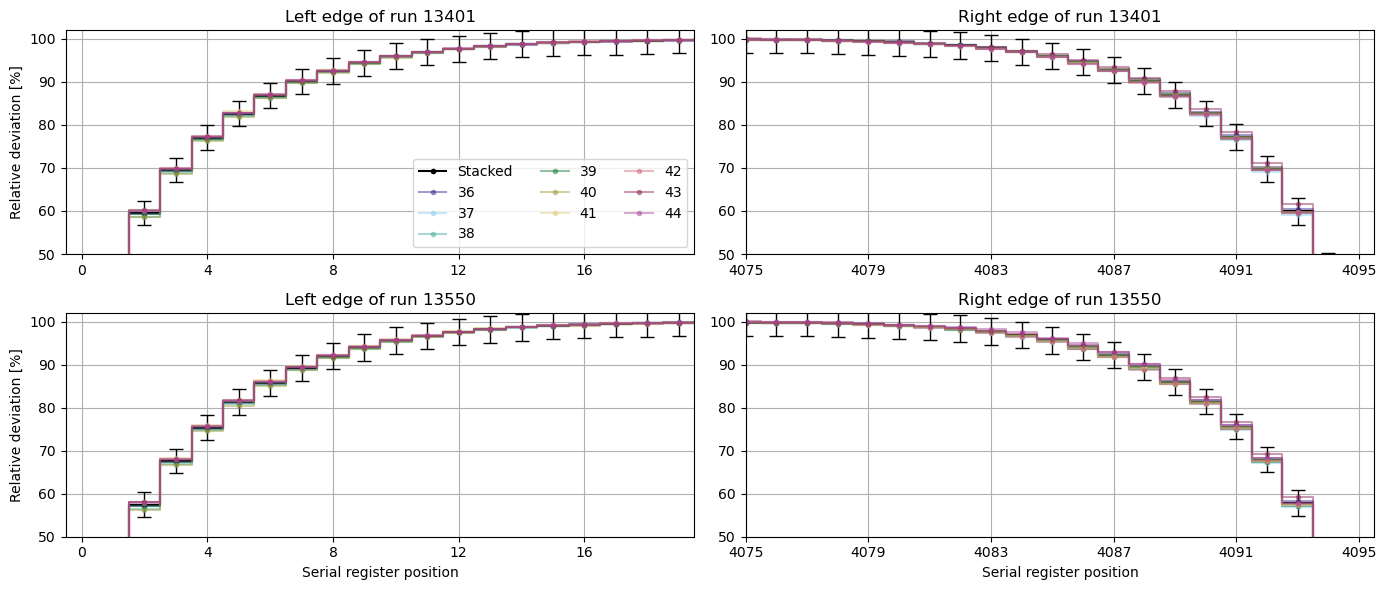

In [12]:
fig, axs = plt.subplots(2,2,figsize=[14,6])

ax = axs.flatten()

ax_iter = 0

# for run 6, 6b
for run in [13401, 13550]:
    # for left, right edge
    for edge in ['left','right']:
        flat_run = collections_interesting[run][3][15:] # slices out everything from "13401_w_2023_24", taking the form RUNID_w_YEAR_week

        stacked_data, stacked_rms, indiv_detectors,indiv_detectors_rms = rsu.stackDetectors(flat_run,raft_11_dets,edge)
        stacked_data, stacked_rms, indiv_detectors,indiv_detectors_rms = stacked_data*100, stacked_rms*100, indiv_detectors*100,indiv_detectors_rms*100

        rsu.addEdgeFigData(fig,ax[ax_iter],stacked_data, stacked_rms, indiv_detectors,indiv_detectors_rms,raft_11_dets,edge,colors,plotIndiv=True)
        
        print(f"Finished for run {run} and {edge} edge")
        ax_iter+=1
        
fig = rsu.formatEdgeFig(fig,ax,[13401, 13550],tight=True,ylims=(50,102))

if save:
    fig.saveFig(figpath+"EdgeComparison.jpg")

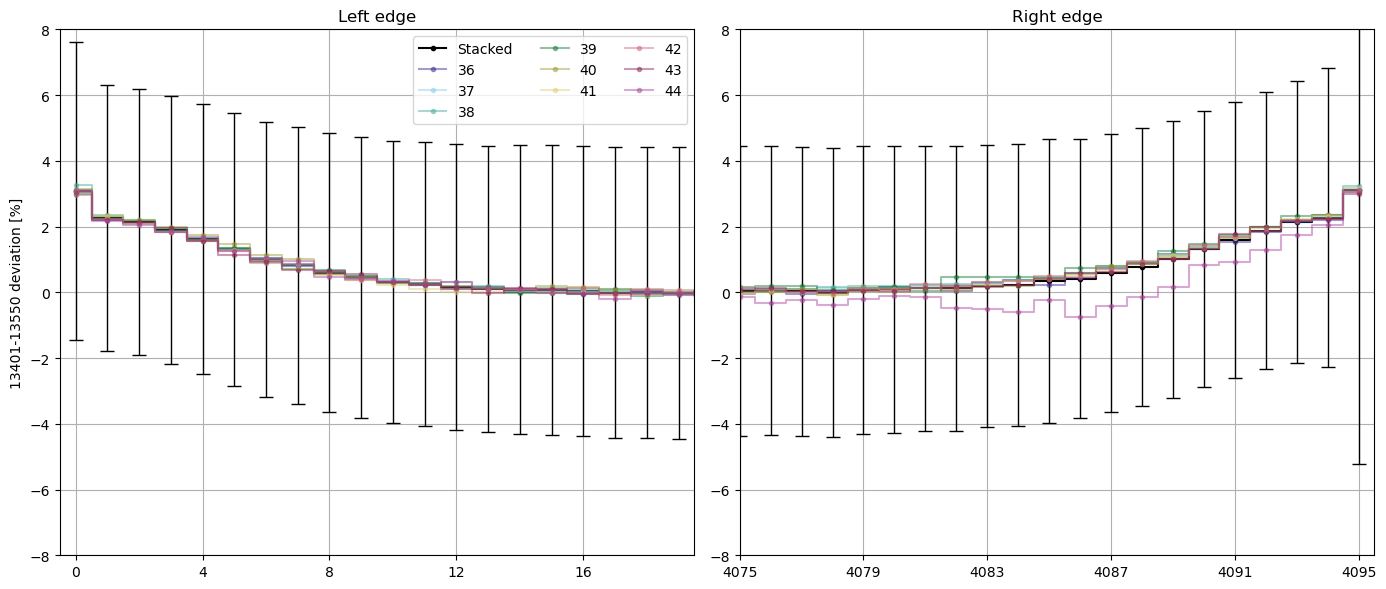

In [11]:
fig, axs = plt.subplots(1,2,figsize=[14,6])

ax = axs.flatten()

ax_iter = 0

# for run 6, 6b
for edge in ['left','right']:
    # for left, right edge
    flat_run = collections_interesting[13401][3][15:] # slices out everything from "13401_w_2023_24", taking the form RUNID_w_YEAR_week

    stacked_data_6,stacked_rms_6,indiv_detectors_6,indiv_detectors_rms_6 = rsu.stackDetectors(flat_run,raft_11_dets,edge)
    stacked_data_6,stacked_rms_6,indiv_detectors_6,indiv_detectors_rms_6 = stacked_data_6*100,stacked_rms_6*100,indiv_detectors_6*100,indiv_detectors_rms_6*100

    flat_run = collections_interesting[13550][3][15:] # slices out everything from "13550_w_2023_41", taking the form RUNID_w_YEAR_week
    stacked_data_6b, stacked_rms_6b,indiv_detectors_6b,indiv_detectors_rms_6b = rsu.stackDetectors(flat_run,raft_11_dets,edge)
    stacked_data_6b, stacked_rms_6b,indiv_detectors_6b,indiv_detectors_rms_6b = stacked_data_6b*100, stacked_rms_6b*100,indiv_detectors_6b*100,indiv_detectors_rms_6b*100

    # Take differences of two sides
    det_diff = stacked_data_6 - stacked_data_6b
    det_indiv_diff = indiv_detectors_6 - indiv_detectors_6b
    # Combine std's the right way
    det_diff_std = np.sqrt(stacked_rms_6**2 + stacked_rms_6b**2)
    det_indiv_diff_std = np.sqrt(indiv_detectors_rms_6**2 + indiv_detectors_rms_6b**2)

    # Now make figures 
    rsu.addEdgeFigData(fig,ax[ax_iter],det_diff,det_diff_std,det_indiv_diff,det_indiv_diff_std,raft_11_dets,edge,colors,plotIndiv=True)

    ax_iter+=1

fig = rsu.formatEdgeFig(fig,ax,[13401, 13550],tight=True,ylims=(-8,8),ylabel="13401-13550 deviation [%]",title=["Left edge","Right edge"])

if save:
    fig.saveFig(figpath+"EdgeComparisonDifference.jpg")

array([5.43253736, 5.02866525, 5.01178941, ..., 5.1228352 , 5.26782253,
       6.19353273])

In [23]:
for run in [13401,13550]:
    dictt = rsu.getImage('flat',collections_interesting[run][3][15:],raft_11_dets[4]).getMetadata().toDict()
    for key,val in zip(dictt.keys(),dictt.values()):
        print(key,val)
    print()

CALIB_CREATION_DATE 2023-06-23
CALIB_CREATION_TIME 04:24:25 PDT
RUNNUM 13401
CCD_MANU E2V
CCD_TYPE CCD250
TESTTYPE SFLAT_HI
IMGTYPE FLAT
DETSIZE [1:4096,1:4004]
BINX 1
BINY 1
CCDGAIN 1.0
CCDNOISE 10.0
CCDSLOT S11
RAFTBAY R11
FIRMWARE 3139500e
PLATFORM ir2-camera
CONTNUM 18ef3ba9
DAQVERS R5-V6.5 2023-06-11T19:40:56Z (d84daf74)
DAQPART camera
DAQFOLD raw
OBSANNOT 
CAMCODE MC
CONTRLLR C
DAYOBS 20230622
HEADVER 2
INSTRUME lsstCam
TELESCOP LSST
TSTAND BOT
SEQFILE FP_E2V_2s_ir2_v26.seq
SEQCKSUM 1010041586
LSST_NUM E2V-CCD250-357
CCD_SERN 17161-06-01
REBNAME LCA-13574-062
RAFTNAME LCA-11021_RTM-020
FPVERS 1.2.0
IHVERS 1.1.2-SNAPSHOT
FILTER None
FILTER1 HIGH
FILTER2 None
CCOBLED nm750
CCOBCURR 0.273
CCOBFLST 0.900037
CCOBFLUX 50000.0
COMMENT ---- Checksums ----
TEMP1 -0.75
TEMP2 -0.0625
TEMP6 -9.3125
DIGPS_V 5.6
ANAPS_V 7.95
CLKHPS_V 15.4
CLKLPS_V 13.575
CLKLPS_I 54.5
ODPS_V 39.15
ODPS_I 72.9167
HTRPS_V 0.0
HTRPS_W 0.0
PCKU_V 3.2967
PCKL_V -6.0
SCKU_V 3.89744
SCKL_V -5.39927
RGU_V 6.09524
OGV 